Clustering coefficient= 0.1333530106257379
Average degree= 4.0
exponent =  -0.0004781339180222483


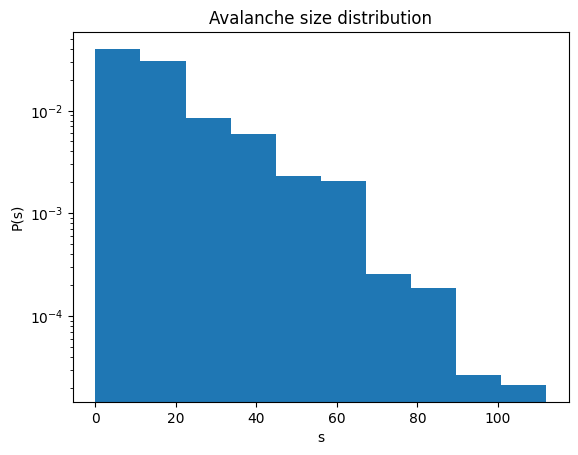

In [10]:
#####Old method
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


class NeuronModel:
    """Class containing attributes and methods for the sand-pile model.
    """
    def __init__(self, size) -> None:
        # TODO: change moment to start sampling size
        # TODO: fix bugs
        #self.network = nx.erdos_renyi_graph(size, 0.5, directed=False) 
        self.network = nx.barabasi_albert_graph(size, m = 2, seed=None, initial_graph=None)
        self.size = size  # Without the sink node

        # Add sink nodes
        self.network.add_node(-1)
        self.network.add_edge(-1, 0)
        self.network.add_edge(-1, 5)
        self.network.add_edge(-1, 13)
        self.network.add_edge(-1, 20)

        # Initialise potentials
        init_potentials = {i: 0.0 for i in range(-1, size)}
        nx.set_node_attributes(self.network, init_potentials, name="potential")

        # Data storage
        self.avalanche_sizes = []

    def get_neuron_degree(self, node_i):
        return nx.degree(self.network)[node_i]

    def get_neuron_potential(self, node_i):
        all_potentials = nx.get_node_attributes(self.network, "potential")

        return all_potentials[node_i]

    def add_neuron_potential(self, node_i, potential):
        curr_potential = self.get_neuron_potential(node_i)

        nx.set_node_attributes(self.network, {node_i: curr_potential + potential}, "potential")

    def set_neuron_potential(self, node_i, potential):
        nx.set_node_attributes(self.network, {node_i: potential}, "potential")

    def get_neighbors(self, node_i):
        return self.network.neighbors(node_i)

    def pick_random_non_sink(self):
        node = list(self.network.nodes)[np.random.randint(0, self.size)]

        return node

    def topple_node(self, node_i):
        self.add_neuron_potential(node_i, -len(list(self.get_neighbors(node_i))))

        for node_j in self.get_neighbors(node_i):
            self.add_neuron_potential(node_j, 1.0)

    def perform_avalanche(self, start_node,t_step):
        unstable = [start_node]
        curr_node = None
        avalanche_size = 0
        while unstable:
            # print(unstable)
            # print(nx.get_node_attributes(self.network, "potential"))
            # print(nx.degree(self.network))
            random_index = np.random.randint(0, len(unstable))
            curr_node = unstable.pop(random_index)

            # Topple unstable node
            self.topple_node(curr_node)
            if (t_step > 8000):
                avalanche_size += 1

            # Check if neighbors are now unstable
            # If yes, add to queue
            for neigh in self.get_neighbors(curr_node):
                potential = self.get_neuron_potential(neigh)
                degree = self.get_neuron_degree(neigh)

                # Skip nodes with degree zero
                if degree == 0:
                    continue

                # Skip sink node
                if neigh == -1:
                    continue

                # Skip if it is already unstable
                if neigh in unstable:
                    continue

                # Node is unstable
                if potential >= degree:
                    unstable.append(neigh)
        return avalanche_size

    def step(self,t_step) -> None: ##Change: added t_step as parameter for perform_avalanche
        # Choose random node
        node_i = self.pick_random_non_sink()

        # Increment grains
        self.add_neuron_potential(node_i, 1.0)

        # print("inc.", node_i)

        # Check for instabilities

        
        if self.get_neuron_potential(node_i) >= self.get_neuron_degree(node_i):
            avalanche_size = self.perform_avalanche(node_i,t_step)
            self.avalanche_sizes.append(avalanche_size)


    def run(self, n_steps):
        for i in range(n_steps):
            self.step(i)
        return self.avalanche_sizes, nx.average_clustering(self.network), sum(dict(self.network.degree()).values())/ self.size


if __name__ == '__main__':
   # m = [1,2,3,5,7,10]
    #for i in range(m):
    model = NeuronModel(20)     #,m[i])

    data, clustering, avg_degree = np.array(model.run(100000), dtype=object)
    print("Clustering coefficient=",clustering)
    print("Average degree=",avg_degree)
    
    #1. Avalanche size time series 
    values, counts = np.unique(a, return_counts=True)
    
    #2. Avalanche size distribution for m = 2
    plt.title("Avalanche size distribution")
    n, bins, patches = plt.hist(data, density=True, log=True)
    bin_center = bins[0:10]+ (bins[1] - bins[0])/2

    def lin_fit(x, a, b):
        return a * x + b

    
    param, param_cov = curve_fit(lin_fit, bin_center[0:8], n[0:8])
    print("exponent = ", param[0])
    #plt.scatter(bin_center, n)
    #plt.scatter(bin_center[0:8],param[0]* bin_center[0:8]+ param[1])
    plt.xlabel("s")
    plt.ylabel("P(s)")
    plt.savefig("BA")
    plt.show()
    
    #3. Avalanche size distribution for varying parameter m ()
    
    
    
    #4. Avalanche size distribution for different nodes() 
    
    #5. Avalanche size Data collapse 
    

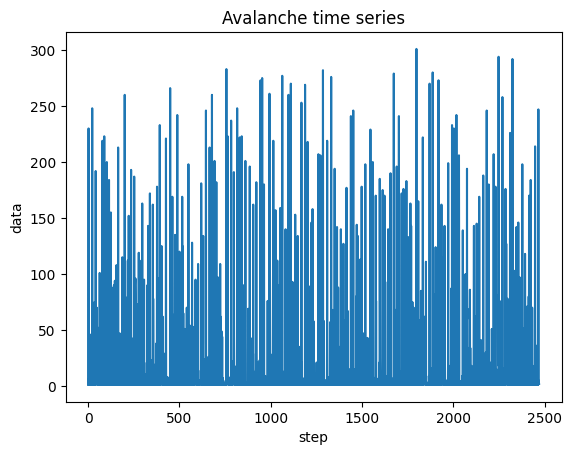

exponent = -1.6949611998344514 for m=2 and N=20


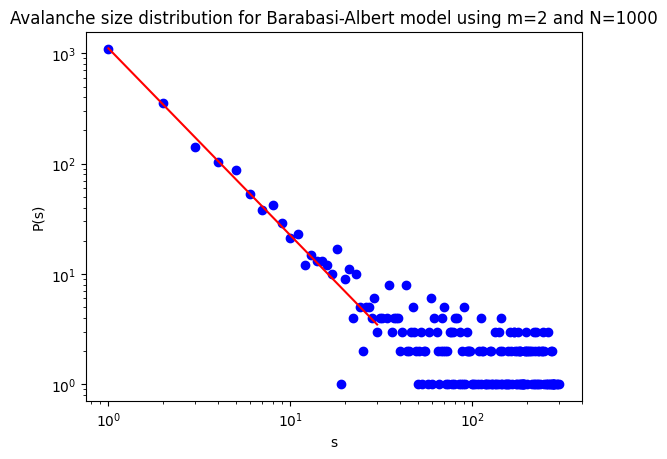

In [29]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


class NeuronModel:
    """Class containing attributes and methods for the sand-pile model.
    """
    def __init__(self, size,m, sample_delay=5000) -> None:
        self.network = nx.barabasi_albert_graph(size, m, seed=None, initial_graph=None)

        # Add sink node connections (boundaries)
        self.network.add_node(-1)

        for comp in nx.connected_components(self.network):
            self.network.add_edge(-1, list(comp)[0])

        assert nx.is_connected(self.network), "All nodes must be able to reach a sink node"

        self.size = size  # Without the sink node

        self.adj_matrix = nx.adjacency_matrix(self.network).toarray()
        self.potentials = np.zeros(self.adj_matrix.shape[0])
        self.degrees = np.array([np.sum(self.adj_matrix[i]) for i in range(self.adj_matrix.shape[0])])

        self.sample_delay = sample_delay

        # Data storage
        self.avalanche_sizes = []

    def get_node_degree(self, node_i):
        return np.sum(self.adj_matrix[node_i])

    def topple_node(self, node_i):
        new_potentials = np.copy(self.potentials)

        # Decrease potential of toppled node
        new_potentials[node_i] -= self.get_node_degree(node_i)

        # Add one unit of potential to each neighbor
        new_potentials[self.adj_matrix[node_i].astype(bool)] += 1

        self.potentials = new_potentials

    def perform_avalanche(self, start_node):
        unstable = np.array([start_node])
        curr_node = None
        avalanche_size = 0

        while unstable.size > 0:
            # Pick a random unstable node
            random_index = np.random.randint(0, len(unstable))
            curr_node = unstable[random_index]

            # Topple unstable node
            self.topple_node(curr_node)
            avalanche_size += 1

            unstable = np.arange(self.potentials.size)[self.potentials >= self.degrees][1:]

        return avalanche_size

    def step(self, iteration) -> None:
        # Choose random node
        node_i = np.random.randint(1, self.size + 1)

        # Increment potential
        self.potentials[node_i] += 1

        # Check for instabilities
        if self.potentials[node_i] >= self.get_node_degree(node_i):
            avalanche_size = self.perform_avalanche(node_i)

            if iteration > self.sample_delay:
                self.avalanche_sizes.append(avalanche_size)


    def run(self, n_steps):
        assert self.sample_delay < n_steps, "Number of steps must be higher than sample delay"

        for i in range(n_steps):
            self.step(i)

        return np.array(self.avalanche_sizes),nx.average_clustering(self.network), sum(dict(self.network.degree()).values())/ self.size


if __name__ == '__main__':
    model = NeuronModel(300,2)

    ##Extract data from the model
    data, clustering_coeff, avg_degree = model.run(10000)
    values, counts = np.unique(data, return_counts=True)
    
##Plots:    

#Function to get linear fit 
    def lin_fit(x, a, b):
        return a * x + b
    
#1. Avalanche size time series 
    plt.title("Avalanche time series")
    plt.plot(data)
    plt.xlabel("step")
    plt.ylabel("data")
    #plt.savefig("")
    plt.show()

    
#2. Avalanche size distribution for m = 2

# Perform the fit on log-transformed data
    log_values = np.log10(values[0:30])
    log_counts = np.log10(counts[0:30])
    param, param_cov = curve_fit(lin_fit, log_values, log_counts)
    print("exponent =", param[0], "for m=2 and N=20")
    
    #Generate the fit values
    fit_values = param[0] * log_values + param[1]

# Plot
    plt.title("Avalanche size distribution for Barabasi-Albert model using m=2 and N=1000")
    plt.scatter(values, counts, color='blue', label='Data Points')
    plt.plot(values[0:30],np.power(10, fit_values), color='red', label='Linear Fit')  # Convert back to original scale
    
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("s")
    plt.ylabel("P(s)")
    plt.legend()
    plt.show()

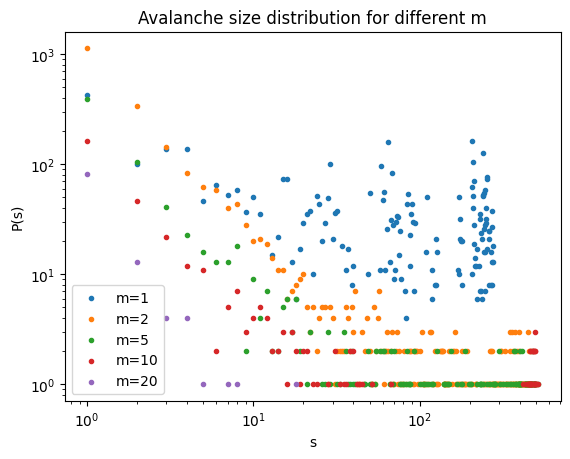

In [30]:
#3. Avalanche size distribution for varying parameter m ()
if __name__ == '__main__':
    m = [1,2,5,10,20]
    
    plt.title("Avalanche size distribution for different m")
    for i in range(len(m)): #go through the list to get different m
        
        #Extract data
        model = NeuronModel(500,m[i])
        data, clustering_coeff, avg_degree = model.run(10000)
        values, counts = np.unique(data, return_counts=True)
        
        #Plot avalanche distribution for specific m parameter
        plt.scatter(values, counts, marker='.',label="m="+str(m[i]))
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("s")
        plt.ylabel("P(s)")
        plt.legend()
#plt.savefig("")
    plt.show()

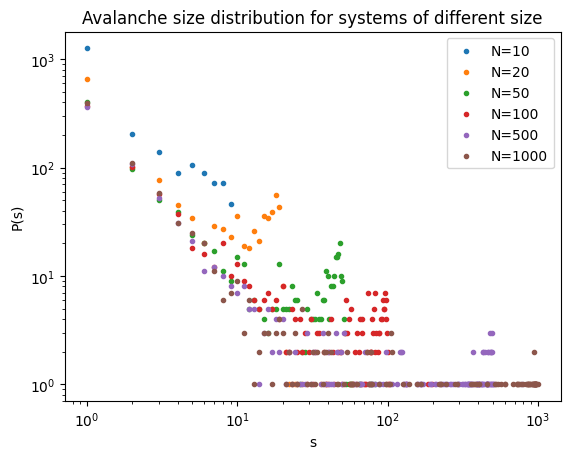

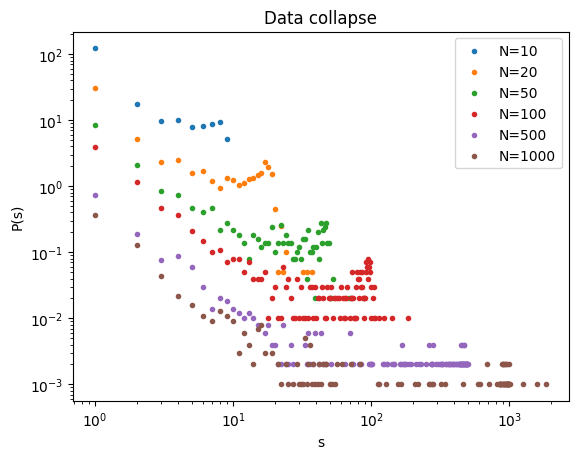

In [87]:
#4. Avalanche size distribution for varying Node numbers ()
if __name__ == '__main__':
    N = [10,20,50,100,500,1000]
    
    plt.title("Avalanche size distribution for systems of different size")
    for i in range(len(N)): #go through the list to get different N
        
        #Extract Data
        model = NeuronModel(N[i],5)
        data, clustering_coeff, avg_degree = model.run(10000)
        values, counts = np.unique(data, return_counts=True)
        
        #Plot avalanche distribution for specific N
        plt.scatter(values, counts, marker='.',label="N="+str(N[i]))
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("s")
        plt.ylabel("P(s)")
        plt.legend()
#plt.savefig("")
    plt.show()

#5. Avalanche size distribution with data collapse
    plt.title("Data collapse")
    for i in range(len(N)):
        
        #Extract Data
        model = NeuronModel(N[i],5)
        data, clustering_coeff, avg_degree = model.run(10000)
        values, counts = np.unique(data, return_counts=True)
        
        #Plot avalanche distribution collapse
        plt.scatter(values, counts/N[i], marker='.',label="N="+str(N[i]))
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("s")
        plt.ylabel("P(s)")
        plt.legend()
#plt.savefig("")
    plt.show()

In [ ]:
## You have your plots
##2. Figure out how data collapse works
##3. Debug the code
##4. Read up on Black swan
##5. Think of way to go from grid to randomize version